# Polarizability Benchmark: PubChemQC Set

1. Creates linear [Huber] regression plot of wb97 vs GFN2 isotropic polarizability values
2. Calculates Mean Absolute Error for wb97 vs GFN2 isotropic polarizability values

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error

### Data Processing

In [2]:
# load data file; was originally received directly from Geoff

file = '../data/PolarizabilityComparison.csv'
df = pd.read_csv(file)
df.tail()

,Folder,Molecule,alpha_GFN2,alpha_wb97,error
17679,pubchemqc,64293607,25.082908,25.083226,0.000318
17680,pubchemqc,21300214,18.176059,18.176337,0.000278
17681,pubchemqc,20782728,15.164950,15.165223,0.000273
17682,pubchemqc,14546131,20.724897,20.725114,0.000217
17683,mike-copolymer,9-72,28.612996,28.613087,0.000090


In [3]:
# drop all rows that are NOT from PubChemQC
df2 = df[df.Folder == 'pubchemqc']

# sort by wB97X values
df2 = df2.sort_values(by=['alpha_wb97'])
df2 = df2.reset_index(drop=True)

df2.tail()

,Folder,Molecule,alpha_GFN2,alpha_wb97,error
8410,pubchemqc,3876310,25.688691,70.286972,44.598281
8411,pubchemqc,58364267,15.331243,96.314135,80.982892
8412,pubchemqc,22889495,23.375069,125.229418,101.854349
8413,pubchemqc,58301030,21.095607,143.897728,122.802120
8414,pubchemqc,6993689,23.286897,182.856970,159.570073


### Method Definition

In [4]:
'''
    Calculates root mean square error

    Parameters
    ---------
    predictions: ndarray of floats
        expected values [based on best fit line]
    observations: ndarray of floats
        observed values
    
    Returns
    -------
    rmse: float
        root mean square error
'''
def calc_rmse(predictions, observations):
    rmse = np.sqrt(((predictions - observations) ** 2).mean())
    return rmse

In [5]:
'''
    Performs linear regression on data set and calculates associated values

    Parameters
    ---------
    x: ndarray of floats
        x values
    y: ndarray of floats
        y values
    intercept: boolean
        if true, calculates y intercept, if false sets y intercept to 0 (forces fit)
    
    Returns
    -------
    lin_regress_var: list of floats
        slope, y-intercept, r^2, root mean square error
'''

def perform_lin_regress(x, y, intercept=True):  
     
    # 2D X array necessary for sklearn
    xi = x.reshape((-1,1))

    model = LinearRegression(fit_intercept = intercept)
    model.fit(xi,y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(xi,y)

    # calculate RMSE
    y_pred = y
    y_true = []
    for val in x: 
        y_tr = slope*val + intercept
        y_true.append(y_tr)
    y_true = np.array(y_true)

    rmse = calc_rmse(y_pred, y_true)
    
    lin_regress_var = [slope, intercept, r_squared, rmse]
    
    return lin_regress_var

In [6]:
'''
    Performs Huber linear regression on data set and calculates associated values [ROBUST TO OUTLIERS]

    Parameters
    ---------
    x: ndarray of floats
        x values
    y: ndarray of floats
        y values
    intercept: boolean
        if true, calculates y intercept, if false sets y intercept to 0 (forces fit)
    
    Returns
    -------
    lin_regress_var: list of floats
        slope, y-intercept, r^2, root mean square error
'''
def perform_huber_regress(x, y, intercept=True):
    
    # 2D X array necessary for sklearn
    xi = x.reshape((-1,1))
    
    model = HuberRegressor(fit_intercept=intercept)
    model.fit(xi, y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(xi, y)
    
    # calculate RMSE
    y_pred = y
    y_true = []
    for val in x: 
        y_tr = slope*val + intercept
        y_true.append(y_tr)
    y_true = np.array(y_true)

    rmse = calc_rmse(y_pred, y_true)
    
    huber_regress_var = [slope, intercept, r_squared, rmse]
    
    return huber_regress_var

In [7]:
# matplotlib global formatting

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rcParams['figure.dpi'] = 300

## Make Multiplot

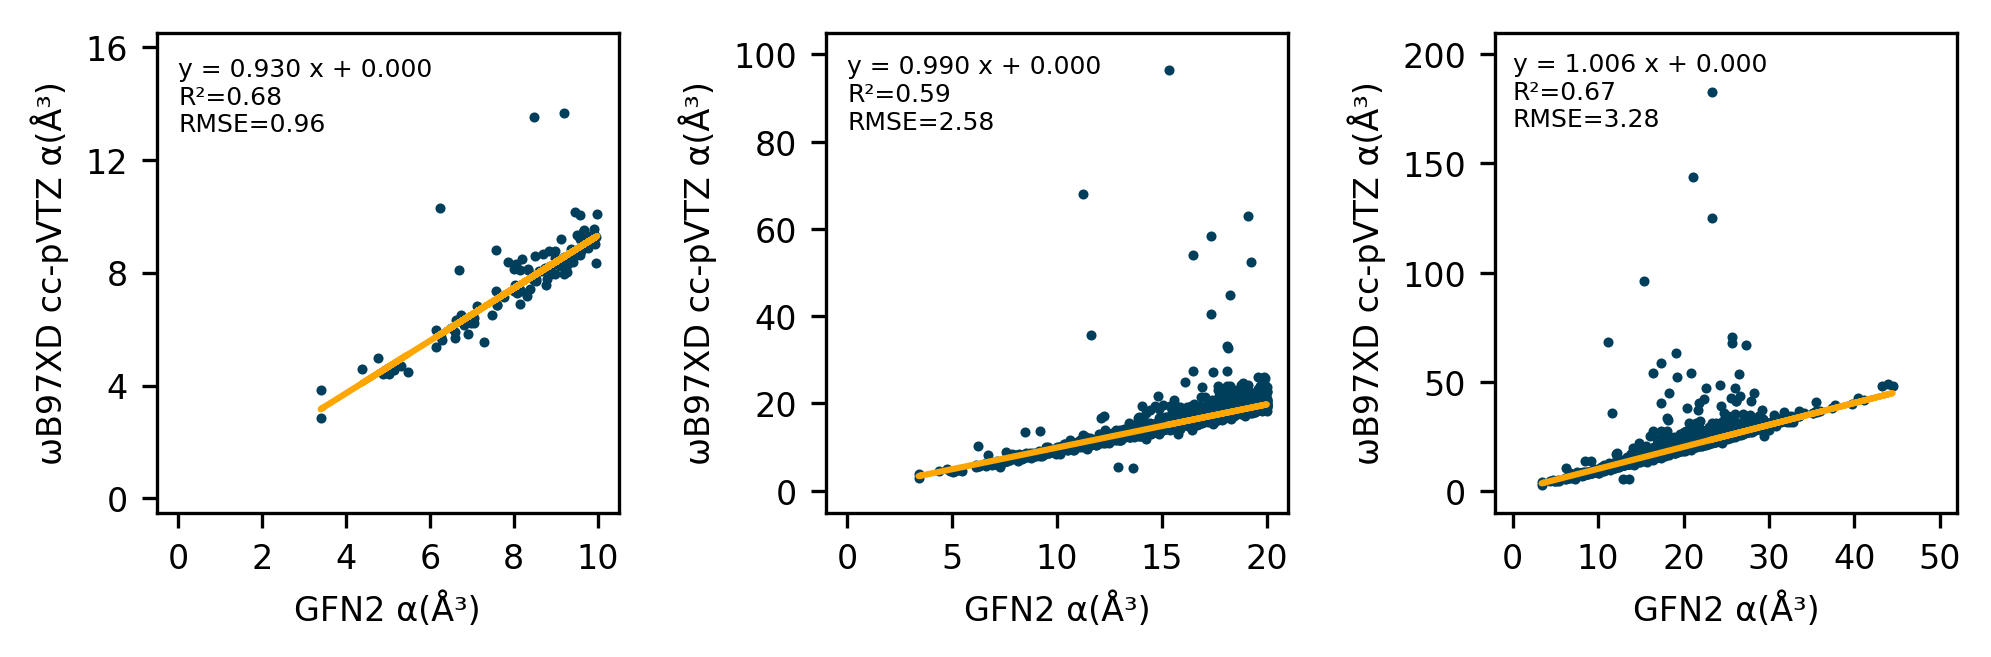

In [8]:
# set up subplot figure
fig, axs = plt.subplots(1, 3)
top = 0.4
bottom = 0
left = 0
right = 1
plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, wspace=0.45)


# SUBPLOT 0: 0-10 Å³
# slice out data
zero_df = df2[df2['alpha_GFN2'] <= 10]

x=zero_df['alpha_GFN2'].values
y=zero_df['alpha_wb97'].values

axs[0].set(ylim=(-0.5,16.5), xlim=(-0.5,10.5))
axs[0].set_xlabel('GFN2 α(Å³)')
axs[0].set_ylabel('ωB97XD cc-pVTZ α(Å³)')
axs[0].set_xticks([0,2,4,6,8,10])
axs[0].set_yticks([0,4,8,12,16])

# perform linear regression
slope, intercept, r_squared, rmserror = perform_huber_regress(x, y, False)

# plot points & regression line
axs[0].scatter(x, y, s=2, c='#003f5c')
axs[0].plot(x, slope*x+intercept, c='#ffa600')

# print regression line equation & r-squared
if intercept < 0:
    y_int = '- %.3f' % abs(intercept)
else: 
    y_int = '+ %.3f' % intercept
axs[0].text(0, 13, 'y = %.3f x %s\nR²=%.2f\nRMSE=%.2f' % (slope, y_int, r_squared, rmserror))


# SUBPLOT 1: 0-20 Å³
# slice out data
one_df = df2[df2['alpha_GFN2'] <= 20]

x=one_df['alpha_GFN2'].values
y=one_df['alpha_wb97'].values

axs[1].set(ylim=(-5,105), xlim=(-1,21))
axs[1].set_xlabel('GFN2 α(Å³)')
axs[1].set_ylabel('ωB97XD cc-pVTZ α(Å³)')
axs[1].set_xticks([0,5,10,15,20])
axs[1].set_yticks([0,20,40,60,80,100])

# perform linear regression
slope, intercept, r_squared, rmserror = perform_huber_regress(x, y, False)

# plot points & regression line
axs[1].scatter(x, y, s=2, c='#003f5c')
axs[1].plot(x, slope*x+intercept, c='#ffa600')

# print regression line equation & r-squared
if intercept < 0:
    y_int = '- %.3f' % abs(intercept)
else: 
    y_int = '+ %.3f' % intercept
axs[1].text(0, 83, 'y = %.3f x %s\nR²=%.2f\nRMSE=%.2f' % (slope, y_int, r_squared, rmserror))


# SUBPLOT 2: All Data
x=df2['alpha_GFN2'].values
y=df2['alpha_wb97'].values

axs[2].set(ylim=(-10,210), xlim=(-2,52))
axs[2].set_xlabel('GFN2 α(Å³)')
axs[2].set_ylabel('ωB97XD cc-pVTZ α(Å³)')
axs[2].set_xticks([0,10,20,30,40,50])
axs[2].set_yticks([0,50,100,150,200])

# perform linear regression
slope, intercept, r_squared, rmserror = perform_huber_regress(x, y, False)

# plot points & regression line
axs[2].scatter(x, y, s=2, c='#003f5c')
axs[2].plot(x, slope*x+intercept, c='#ffa600')

# print regression line equation & r-squared
if intercept < 0:
    y_int = '- %.3f' % abs(intercept)
else: 
    y_int = '+ %.3f' % intercept
axs[2].text(0, 167, 'y = %.3f x %s\nR²=%.2f\nRMSE=%.2f' % (slope, y_int, r_squared, rmserror))

# plt.savefig('pubchem_huber_multiplot.pdf', transparent=False, bbox_inches='tight')
# plt.savefig('pubchem_huber_multiplot.png', transparent=False, bbox_inches='tight')

plt.show()

### Calculate Mean Absolute Error

In [9]:
# for 0-10 Å³ data
ten_df = df2[df2['alpha_GFN2'] <= 10]
y_true_10 = ten_df['alpha_wb97'].values
y_pred_10 = ten_df['alpha_GFN2'].values

mae_10 = mean_absolute_error(y_true_10, y_pred_10)

mae_10

0.752132118448315

In [10]:
# for 0-20 Å³ data
twenty_df = df2[df2['alpha_GFN2'] <= 20]
y_true_20 = twenty_df['alpha_wb97'].values
y_pred_20 = twenty_df['alpha_GFN2'].values

mae_20 = mean_absolute_error(y_true_20, y_pred_20)

mae_20

0.7509446607301473

In [12]:
# for all data
y_true = df2['alpha_wb97'].values
y_pred = df2['alpha_GFN2'].values

mae = mean_absolute_error(y_true, y_pred)

mae

0.8391300372051089